In [151]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from sklearn.metrics import f1_score

def show_binary_image(image, title=None):
    # Converts from one colour space to the other. this is needed as RGB
    # is not the default colour space for OpenCV
    # Show the image
    plt.imshow(image, cmap=plt.cm.gray)
    # remove the axis / ticks for a clean looking image
    plt.xticks([])
    plt.yticks([])
    # if a title is provided, show it
    if title is not None:
        plt.title(title)
    plt.show()

image1 = cv2.imread("images/cells/9343 AM.bmp", cv2.IMREAD_GRAYSCALE) # Retrieve the grayscale image. 
image2 = cv2.imread("images/cells/10905 JL.bmp", cv2.IMREAD_GRAYSCALE) # Retrieve the grayscale image. 
image3 = cv2.imread("images/cells/43590 AM.bmp", cv2.IMREAD_GRAYSCALE) # Retrieve the grayscale image. 

ground_truth1 = cv2.imread("images/cells/9343 AM Edges.bmp", cv2.IMREAD_GRAYSCALE) # Retrieve the grayscale image. 
ground_truth2 = cv2.imread("images/cells/10905 JL Edges.bmp", cv2.IMREAD_GRAYSCALE) # Retrieve the grayscale image. 
ground_truth3 = cv2.imread("images/cells/43590 AM Edges.bmp", cv2.IMREAD_GRAYSCALE) # Retrieve the grayscale image. 

def preprocess_ground_truth(image: np.ndarray):
    # Create a new array where True is set for elements that are 0 in the original image, and False otherwise
    mask = image == 0
    
    # Convert the boolean mask to integer (1 for True, 0 for False)
    preprocessed_image = mask.astype(int)
    
    return preprocessed_image


ground_truth1 = preprocess_ground_truth(ground_truth1)
ground_truth2 = preprocess_ground_truth(ground_truth2)
ground_truth3 = preprocess_ground_truth(ground_truth3)

# Open the GIF image
gif_image = Image.open('images/shakey.150.gif')

# Let's just take the first frame (index 0) for the static PNG
gif_image.seek(0) 

# Save the current frame as PNG
gif_image.save('images/shakey.png')

# Import PNG
shakey_image = cv2.imread("images/shakey.png", cv2.IMREAD_GRAYSCALE)

def unsharp_masking(image, kernel_size=(3,3), sigma=2, weight_original=5, weight_edges=3, gamma=2):
    gaussian_blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    edges = cv2.subtract(image, gaussian_blurred)
    enhanced_image = cv2.addWeighted(image, weight_original, edges, weight_edges, gamma)
    return enhanced_image


sharp_image1 = unsharp_masking(image1)
sharp_image2 = unsharp_masking(image2)
sharp_image3 = unsharp_masking(image3)


# Function to apply high-pass filter directly to an image array
def apply_high_pass_filter(image):
    # Apply Gaussian blur to create a low-pass filter effect
    blurred_image = cv2.GaussianBlur(image, (49, 49), 8)
    
    # Subtract the blurred (low-pass filtered) image from the original to get high-pass filtered image
    high_pass_filtered_image = cv2.subtract(image, blurred_image)
    
    return high_pass_filtered_image


# Apply the high-pass filter to each image
sharp_filter_image1 = apply_high_pass_filter(sharp_image1)
sharp_filter_image2 = apply_high_pass_filter(sharp_image2)
sharp_filter_image3 = apply_high_pass_filter(sharp_image3)


In [152]:

def calculate_f1_score(ground_truth: np.ndarray, prediction: np.ndarray) -> float:
    """
    Calculate the F1 score between the ground truth and the prediction.

    Parameters:
    - ground_truth (np.ndarray): The ground truth binary image (edges marked with 1).
    - prediction (np.ndarray): The predicted edge binary image.

    Returns:
    - float: The F1 score as a float between 0 and 1, where 1 represents perfect agreement.
    """
    # Flatten arrays to 1D for compatibility with f1_score function
    ground_truth_flat = ground_truth.flatten()
    prediction_flat = prediction.flatten()
    
    # Calculate and return F1 score
    return f1_score(ground_truth_flat, prediction_flat)

scharr_x = np.array([[47, 0, -47], 
                    [162, 0, -162],
                    [47, 0, -47]])

scharr_y = scharr_x.T 

def magnitude_img(G_x: np.ndarray, G_y: np.ndarray) -> np.ndarray:
    """
    Computes the magnitude of the gradient for an image given its horizontal (G_x)
    and vertical (G_y) gradients.

    Parameters:
    - G_x (np.ndarray): The gradient of the image in the x-direction (horizontal).
    - G_y (np.ndarray): The gradient of the image in the y-direction (vertical).

    Returns:
    - np.ndarray: The magnitude of the gradient at each point in the image. The returned
      array is of the same shape as the input arrays and contains the computed gradient
      magnitudes.
    """
    return np.sqrt(G_x**2 + G_y**2) 

def otsus_thresholding(image:np.ndarray, plot: bool = False) -> np.ndarray:
    # Compute histogram with correct bin edges
    histogram_bins = np.arange(257)  # Includes an extra edge to have 256 bins
    histogram, _ = np.histogram(image.ravel(), bins=histogram_bins, range=(0, 256))
    
    # Normalize histogram
    normalized_histogram = histogram / histogram.sum()
    
    # Finding bin centers for calculating cumulative mean correctly
    bin_centers = (histogram_bins[:-1] + histogram_bins[1:]) / 2
    
    # Compute cumulative sum and cumulative mean
    cumulative_sum = np.cumsum(normalized_histogram)
    cumulative_mean = np.cumsum(bin_centers * normalized_histogram)
    
    # Initialize variables for between class variance
    between_class_variance = np.zeros(256)
    total_mean = cumulative_mean[-1]
    
    # Iterate over all possible thresholds to compute between-class variance
    for t in range(1, 256):
        probability_class1 = cumulative_sum[t]
        probability_class2 = 1 - probability_class1
        mean_class1 = cumulative_mean[t] / probability_class1 if probability_class1 > 0 else 0
        mean_class2 = (total_mean - cumulative_mean[t]) / probability_class2 if probability_class2 > 0 else 0
        
        # Calculate between-class variance
        between_class_variance[t] = probability_class1 * probability_class2 * (mean_class1 - mean_class2) ** 2
    
    # Find the threshold that maximizes the between-class variance
    optimal_threshold = np.argmax(between_class_variance)
    
    # Apply the threshold to create a binary image
    thresh = image.copy()
    thresh[image > optimal_threshold] = 255
    thresh[image <= optimal_threshold] = 0
    
    if plot:
        # Plotting
        plt.figure(figsize=(10, 6))
        ax1 = plt.gca()  # Get current axis for the histogram
        ax1.bar(bin_centers, histogram, width=0.5, alpha=0.7)
        ax1.set_ylabel('Frequency')
        ax1.set_xlabel('Intensity Value')
        
        ax2 = ax1.twinx()  # Secondary axis for between-class variance
        ax2.plot(bin_centers, between_class_variance, color='green', linestyle=':', label='Inter-class Variance')
        ax2.set_ylabel('Inter-class Variance')
        
        # Add vertical line for optimal threshold
        ax1.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold: {optimal_threshold}')
        
        plt.xlim(5, 100)
        
        # Adjusting legend
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='upper right')
        
        plt.tight_layout()  # Adjust layout to not cut off labelss
        plt.show()

    return thresh

def apply_otsu_scharr(image: np.ndarray, threshold: float = 100) -> np.ndarray: 
    
    image = otsus_thresholding(image)

    G_x = scipy.signal.convolve2d(image, scharr_x, mode="same")
    G_y = scipy.signal.convolve2d(image, scharr_y, mode="same")

    # Calculate the magnitude and direction of the gradient at each pixel
    magnitude_image = magnitude_img(G_x, G_y)  # Magnitude of gradient
    final_edges = magnitude_image > threshold

    return final_edges


otsu_scharr_image1 = apply_otsu_scharr(image1, threshold=1)
otsu_scharr_image2 = apply_otsu_scharr(image2, threshold=1)
otsu_scharr_image3 = apply_otsu_scharr(image3, threshold=1)

ground_truth_images = [ground_truth1, ground_truth2, ground_truth3]


In [153]:
import cv2
import numpy as np
from hyperopt import hp, fmin, tpe, Trials

def apply_morphological_operation(image: np.ndarray, kernel_size: int, struct_element_shape: int, morph_op: int) -> np.ndarray:
    """
    Applies a morphological operation using a structuring element of the specified size and shape.

    Parameters:
    - image (np.ndarray): The input image.
    - kernel_size (int): The size of the square kernel.
    - struct_element_shape (int): The shape of the structuring element (cv2.MORPH_RECT, cv2.MORPH_ELLIPSE, cv2.MORPH_CROSS).
    - morph_op (int): The morphological operation (cv2.MORPH_GRADIENT, cv2.MORPH_TOPHAT, cv2.MORPH_OPEN, cv2.MORPH_CLOSE).

    Returns:
    - np.ndarray: The resulting image after the morphological operation.
    """
    # Create a deep copy of the image to ensure the original is not modified
    image_copy = np.copy(image)

    kernel = cv2.getStructuringElement(struct_element_shape, (kernel_size, kernel_size))
    result = cv2.morphologyEx(image_copy, morph_op, kernel)
    otsu_scharr_image = apply_otsu_scharr(result)  # Assumes this function does not modify its input in-place
    
    return otsu_scharr_image

def objective(params):
    kernel_size = int(params['kernel_size'])
    struct_element_shape = int(params['struct_element_shape'])
    morph_op = int(params['morph_op'])
    f1_scores = []
    for image, ground_truth in zip([image1, image2, image3], ground_truth_images):
        predicted_edges = apply_morphological_operation(image, kernel_size, struct_element_shape, morph_op)
        f1 = calculate_f1_score(ground_truth, predicted_edges)
        f1_scores.append(f1)
    avg_f1 = np.mean(f1_scores)
    return -avg_f1

# Define the search space
space = {
    'kernel_size': hp.quniform('kernel_size', 1, 255, 2),
    'struct_element_shape': hp.choice('struct_element_shape', [cv2.MORPH_RECT, cv2.MORPH_ELLIPSE, cv2.MORPH_CROSS]),
    'morph_op': hp.choice('morph_op', [cv2.MORPH_GRADIENT, cv2.MORPH_TOPHAT, cv2.MORPH_OPEN, cv2.MORPH_CLOSE])
}

# Run the optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=400, trials=trials)

best_kernel_size = int(best['kernel_size'])
best_struct_element_shape = ['MORPH_RECT', 'MORPH_ELLIPSE', 'MORPH_CROSS'][best['struct_element_shape']]
best_morph_op = ['MORPH_GRADIENT', 'MORPH_TOPHAT', 'MORPH_OPEN', 'MORPH_CLOSE'][best['morph_op']]

print(f"Best kernel size: {best_kernel_size}, Best Structuring Element Shape: {best_struct_element_shape}, Best Morphological Operation: {best_morph_op}")

100%|██████████| 400/400 [07:48<00:00,  1.17s/trial, best loss: -0.9356139185538459]
Best kernel size: 96, Best Structuring Element Shape: MORPH_RECT, Best Morphological Operation: MORPH_TOPHAT


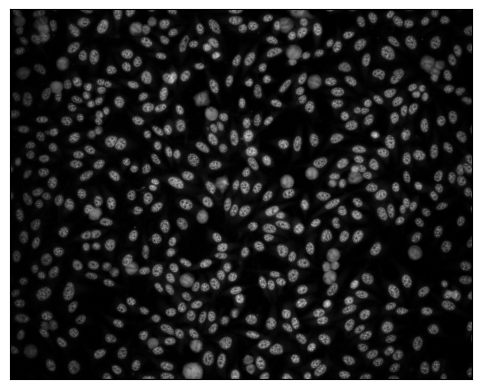

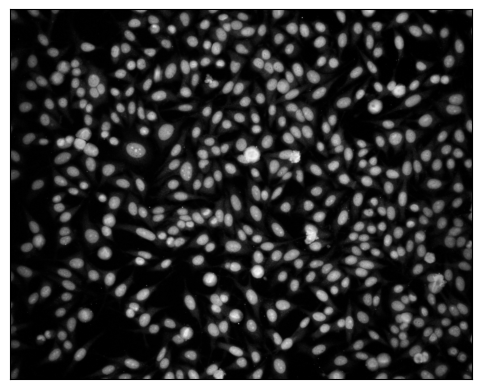

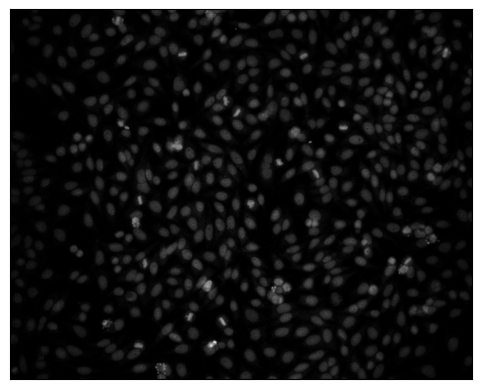

In [157]:
kernel_size = 112
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))

# Apply the Top-hat Transform
enhanced_image1 = cv2.morphologyEx(image1, cv2.MORPH_TOPHAT, kernel)
enhanced_image2 = cv2.morphologyEx(image2, cv2.MORPH_TOPHAT, kernel)
enhanced_image3 = cv2.morphologyEx(image3, cv2.MORPH_TOPHAT, kernel)

show_binary_image(enhanced_image1)
show_binary_image(enhanced_image2)
show_binary_image(enhanced_image3)

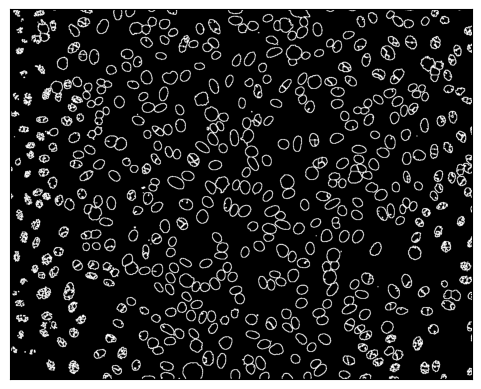

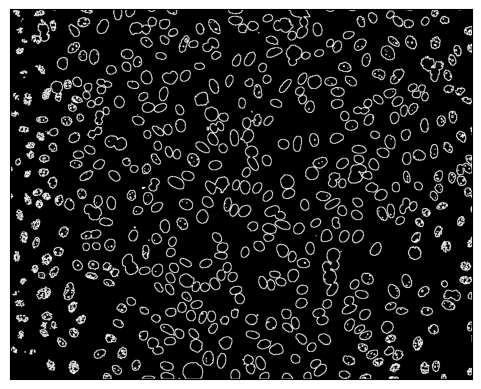

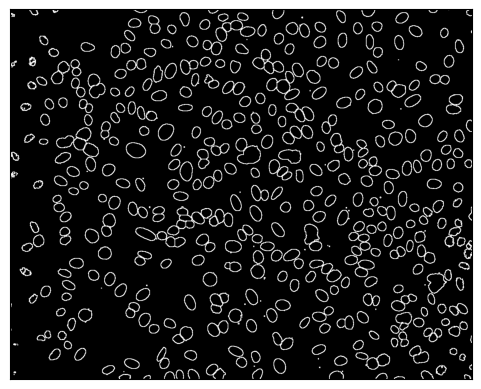

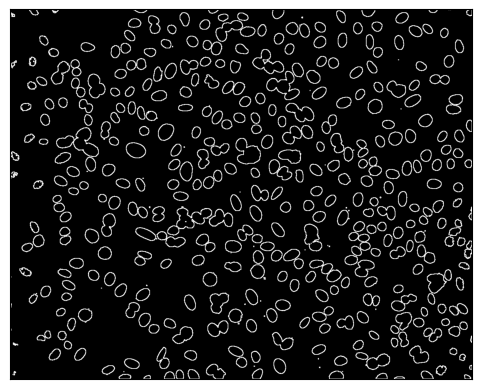

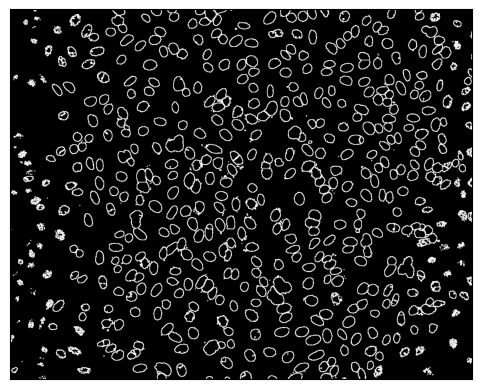

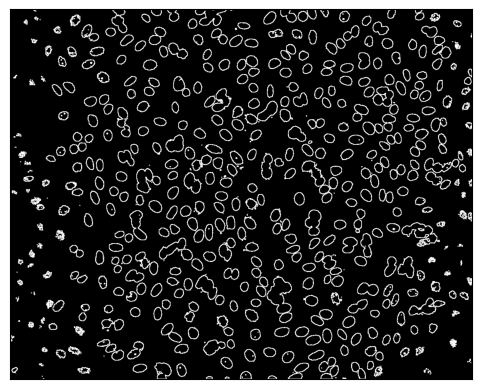

In [158]:
# enhanced_image1 = unsharp_mask(image1, 0.10627836069636026, 1.3408156613254996)
# enhanced_image2 = unsharp_mask(image2, 0.10627836069636026, 1.3408156613254996)
# enhanced_image3 = unsharp_mask(image3, 0.10627836069636026, 1.3408156613254996)


# otsu_scharr_image1 = apply_otsu_scharr(enhanced_image1, threshold=1)
# otsu_scharr_image2 = apply_otsu_scharr(enhanced_image2, threshold=1)
# otsu_scharr_image3 = apply_otsu_scharr(enhanced_image3, threshold=1)




otsu_scharr_image1 = apply_otsu_scharr(enhanced_image1, threshold=1)
otsu_scharr_image2 = apply_otsu_scharr(enhanced_image2, threshold=1)
otsu_scharr_image3 = apply_otsu_scharr(enhanced_image3, threshold=1)


# otsu_scharr_image1 = apply_otsu_scharr(image1, threshold=1)
# otsu_scharr_image2 = apply_otsu_scharr(image2, threshold=1)
# otsu_scharr_image3 = apply_otsu_scharr(image3, threshold=1)

show_binary_image(ground_truth1)
show_binary_image(otsu_scharr_image1)
show_binary_image(ground_truth2)
show_binary_image(otsu_scharr_image2)
show_binary_image(ground_truth3)
show_binary_image(otsu_scharr_image3)

In [159]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error

def compute_metrics(ground_truth, prediction):
    
    ground_truth = ground_truth.flatten()
    prediction = prediction.flatten()
    
    accuracy = accuracy_score(ground_truth, prediction)
    precision = precision_score(ground_truth, prediction)
    recall = recall_score(ground_truth, prediction)
    F1 = f1_score(ground_truth, prediction)
    MSE = mean_squared_error(ground_truth, prediction)
    
    return accuracy, precision, recall, F1, MSE
# Compute metrics for the first image and print them
accuracy, precision, recall, F1, MSE = compute_metrics(ground_truth1, otsu_scharr_image1)
print(f"OS IMAGE 1: Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {F1}\nMSE: {MSE}\n")

# Compute metrics for the second image and print them
accuracy, precision, recall, F1, MSE = compute_metrics(ground_truth2, otsu_scharr_image2)
print(f"OS IMAGE 2: Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {F1}\nMSE: {MSE}\n")

# Compute metrics for the third image and print them
accuracy, precision, recall, F1, MSE = compute_metrics(ground_truth3, otsu_scharr_image3)
print(f"OS IMAGE 3: Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {F1}\nMSE: {MSE}\n")

OS IMAGE 1: Accuracy: 0.9898719787597656
Precision: 0.9759160296196889
Recall: 0.9225262776368249
F1 Score: 0.9484704156137552
MSE: 0.010128021240234375

OS IMAGE 2: Accuracy: 0.9907196044921875
Precision: 0.9512986368777159
Recall: 0.9296614441945241
F1 Score: 0.9403555912955645
MSE: 0.0092803955078125

OS IMAGE 3: Accuracy: 0.9845436096191407
Precision: 0.9577037999898712
Recall: 0.8815330469035281
F1 Score: 0.9180411432732569
MSE: 0.015456390380859376

